# 10. 트랜스포머로 만드는 대화형 챗봇 [프로젝트]
---

영어로 만들었던 챗봇을 한국어 데이터로 바꿔서 훈련시켜봅시다.

1. 필요 함수들 설정
2. 데이터 불러오기 및 전처리하기
3. 모델 정의 및 학습하기
4. 챗봇 테스트하기

In [1]:
# 필요한 패키지를 임포트
import tensorflow as tf
import tensorflow_datasets as tfds # TensorFlow Datasets 라이브러리를 가져온다. 
                                   # 이 라이브러리는 다양한 기계 학습 데이터셋을 쉽게 다운로드하고 사용할 수 있도록 도와준다.
import os # 운영체제와 상호 작용하기 위한 os 모듈을 불러온다.
import re # 정규 표현식을 사용하기 위한 re 모듈을 불러온다. 정규표현식은 문자열의 검색, 추출, 대체 등을 위한 강력한 도구이다.
import numpy as np # NumPy 라이브러리를 불러온다. NumPy는 다차원 배열과 행렬 연산을 위한 파이썬 라이브러리로, 데이터 처리에 유용
import matplotlib.pyplot as plt # Matplotlib 라이브러리를 가져온다. 
                                # Matplotlib은 데이터 시각화를 위한 라이브러리로, 그래프 및 차트를 그리는 데 사용

    
print(tf.__version__)

2.6.0


### 1. 필요 함수들 설정

#### 1. 포지셔널 인코딩 레이어

In [2]:
# 포지셔널 인코딩 레이어 - 트랜스포머 모델에서 입력 데이터에 위치 정보를 부여하는 데 사용된다. 
# 포지셔널 인코딩은 단어의 순서를 고려하여 모델이 문장 내 단어의 상대적인 위치에 대한 정보를 학습할 수 있게 한다..
class PositionalEncoding(tf.keras.layers.Layer): # 이 클래스는 tf.keras.layers.Layer 클래스를 상속받아 사용자 정의 레이어를 만든다

  def __init__(self, position, d_model): # 클래스 초기화 메서드, position: 시퀀스의 최대 길이(최대 포지션), d_model: 모델의 임베딩 차원(하나의 포지션에 대한 차원)
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model) # 포지셔널 인코딩 값을 계산하여 pos_encoding 변수에 저장, 
                                                                    # 이 값은 후에 입력 데이터에 더해져서 포지셔널 인코딩이 적용

  def get_angles(self, position, i, d_model): # 각도를 계산하는 메서드, position은 시퀀스 내 각 위치, i는 임베딩 차원 내의 인덱스, d_model은 임베딩 차원
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model): # 포지셔널 인코딩 값을 계산하는 메서드, 각 위치 및 임베딩 차원에 대한 각도를 계산하고 sin과 cosine 함수를 적용하여 인코딩 값을 생성
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model) # get_angles 메서드를 사용하여 각 위치와 임베딩 차원에 대한 각도를 계산

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2]) # 계산된 각도를 이용하여 sin 함수 및 cosine 함수를 적용

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0) # sin과 cosine을 교차되도록 스택
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) # 차원을 재배열
    pos_encoding = tf.reshape(pos_encoding, [position, d_model]) # 최종적으로 포지셔널 인코딩 값을 정리

    pos_encoding = pos_encoding[tf.newaxis, ...] # 포지셔널 인코딩 값을 배치 차원을 추가하여 확장
    return tf.cast(pos_encoding, tf.float32) # 최종적으로 계산된 포지셔널 인코딩 값을 반환하며, 자료형을 tf.float32로 변환

  def call(self, inputs): # 레이어를 호출할 때 실행되는 메서드, 입력에 포지셔널 인코딩 값을 더하여 반환. 이를 통해 입력 데이터에 상대적인 위치 정보가 부여
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")

슝=3


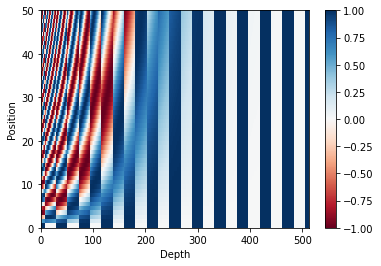

In [3]:
# 행의 크기가 50, 열의 크기가 512인 행렬을 만드는 코드를 완성하여 입력 벡터 모양을 시각화
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

#### 2. 스케일드 닷 프로덕트 어텐션 함수

In [4]:
# 스케일드 닷 프로덕트 어텐션 함수 - 주어진 쿼리, 키, 밸류에 대한 어텐션 메커니즘을 적용(어텐션 함수와 직접적인 관련은 없다)
def scaled_dot_product_attention(query, key, value, mask): # 어텐션 메커니즘을 사용하여 입력 쿼리(query), 키(key), 밸류(value)에 가중치를 부여하여 출력을 생성
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True) # 쿼리와 키 간의 닷 프로덕트를 계산
                                                      # (닷 프로덕트는 두 벡터 간의 내적을 의미하며, 여기서는 어텐션 가중치를 계산하는 주용한 부분이다.)

  # 가중치를 정규화(스케일드 닷 프로덕트 어텐션에서 스케일링을 수행하는 부분)
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth) # 계산된 닷 프로덕트 값을 키 벡터의 차원 수로 나워 정규화

  # 패딩에 마스크 추가
  if mask is not None: # 만약 마스크('mask')가 주어졌다면, 패딩을 위해 어텐션 로짓에 마스크를 더한다.
    logits += (mask * -1e9) # 이렇게 함으로써 어텐션 연산 시에 특정 위치를 무시할 수 있다.

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1) # 정규화된 어텐션 로짓에 소프트맥스 함수를 적용하여 어텐션 가중치를 얻는다.
                                                     # 소프트맥스 함수를 통해 각 키와 쿼리의 관련성을 확률로 표현 

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value) # 어텐션 가중치와 밸류('value')의 닷 프로덕트를 계산하여 어텐션 출력을 얻는다
  return output # 최종 어텐션 출력을 반환

print("슝=3")

슝=3


#### 3. 멀티 헤드 어텐션 구현 함수

* 내부적으로는 스케일드 닷 프로덕트 어텐션 함수를 호출한다.

In [5]:
# Multi-Head Attention: 여러 개의 어텐션 헤드를 사용해 입력에 대한 다양한 관점에서 정보를 추출하는 메커니즘
class MultiHeadAttention(tf.keras.layers.Layer): # tf.keras.layers.Layer를 상속받아 Multi-Head Attention 레이어를 정의


  def __init__(self, d_model, num_heads, name="multi_head_attention"): # 클래스 초기화 메서드, 
                                                                       # 모델의 차원(d_model)과 헤드의 개수(num_heads)를 인자로 받는다
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0 # 입력 차원(d_model)이 헤드의 수로 나누어 떨어지지 않으면 예외를 발생시킴
                                         # assert 문은 주어진 조건이 False인 경우 AssertionError 예외를 발생
    self.depth = d_model // self.num_heads  # 각 헤드의 깊이(depth)를 계산

    self.query_dense = tf.keras.layers.Dense(units=d_model) # Query, Key, Value, 그리고 최종 결과에 대한 Dense 레이어를 정의
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size): # 주어진 입력을 여러 헤드로 나누는 메서드
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth)) # 입력의 형태를 조정
    return tf.transpose(inputs, perm=[0, 2, 1, 3]) # 특정 차원을 전치(transpose)하여 헤드를 나눔

  def call(self, inputs): # 실제로 레이어를 호출하는 메서드
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0] # 입력으로부터 query, key, value, 그리고 mask를 추출하고, 배치 크기를 가져옴

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다(각각의 헤드로 나누기 위해 split_heads 메서드를 호출)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask) # 스케일드 닷 프로덕트 어텐션 함수를 호출하여 어텐션 연산을 수행

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3]) # 어텐션 결과를 다시 정렬

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model)) # 각 헤드의 결과를 다시 하나의 텐서로 결합

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs # 최종 결과를 반환
print("슝=3")

슝=3


#### 4. 패딩 마스킹 구현 함수

In [6]:
# 패딩 마스크는 주로 트랜스포머 모델에서 어텐션 연산 시에 패딩된 토큰들을 무시하기 위해 사용
def create_padding_mask(x): # 패딩된 부분을 감지하는 패딩 마스크를 생성하는 함수
  mask = tf.cast(tf.math.equal(x, 0), tf.float32) # 입력 텐서 'x'와 0을 비교, 
                                                  # tf.math.equal은 입력과 0이 동일한지 여부를 검사하고, 동일하면 True를, 그렇지 않으면 False를 반환
                                                  # 이전 단계에서 얻은 불리언 값을 부동 소수점 타입으로 변환(True는 1.0으로, False는 0.0으로 변환)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :] # 마스크의 차원을 조정
                                            # tf.newaxis는 새로운 축(axis)을 추가, tf.newaxis를 사용하여 마스크에 새로운 축을 추가
                                            # 최종적으로 반환되는 마스크의 형태는 (batch_size, 1, 1, sequence_length)


# 이 함수는 주로 토크나이저에서 패딩된 부분을 감지하고, 이를 통해 어텐션 연산에서 패딩 토큰들을 무시하도록 하는 데 사용됩니다. 
# 패딩 토큰들은 모델의 입력 시퀀스 길이를 맞추기 위해 추가된 것이지만, 어텐션 연산 시에는 무시되어야 합니다.


슝=3


이 함수에 정수 시퀀스를 입력으로 하면, 이 함수는 숫자가 0인 부분을 체크한 벡터를 리턴한다.

두 개의 정수 시퀀스를 입력으로 해보고, 각각 어떤 결과가 나오는지 보겠다.

In [7]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


두 정수 시퀀스에 대해서 각각 결과가 출력되는데, 오직 숫자가 0인 위치에서만 숫자 1이 나오고 숫자 0이 아닌 위치에서는 숫자 0인 벡터를 출력한다.

어텐션 연산 시에 패딩 마스킹을 참고하면 불필요하게 숫자 0을 참고하지 않게 할 수 있겠다.

In [8]:
# 룩어헤드 마스크는 모델이 현재 위치 이후의 토큰을 참조하지 못하도록 만들어 모델이 미래의 정보를 사용하지 못하도록 한다.
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1] # 입력 텐서 'x'의 시퀀스 길이를 가져온다, 
                           # tf.shape(x)[1]은 시퀀스의 두 번째 차원(토큰의 개수)의 크기를 나타낸다
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0) # tf.ones((seq_len, seq_len))는 모든 원소가 1인 행렬을 생성
                                                                                # tf.linalg.band_part는 행렬의 특정 부분을 0으로 만드는데 사용됩니다. 
                                                                                # 여기서는 -1과 0을 인자로 전달하여 주 대각선 아래의 모든 원소를 0으로 만듦
                                                                                # 1 - ...를 통해 주 대각선 아래의 부분이 1이 되고, 주 대각선과 그 위의 부분은 0이 되는 룩어헤드 마스크를 생성
  padding_mask = create_padding_mask(x) # 이전에 정의한 create_padding_mask 함수를 사용하여 입력 시퀀스에 대한 패딩 마스크를 생성
  return tf.maximum(look_ahead_mask, padding_mask) # 룩어헤드 마스크와 패딩 마스크 중에서 더 큰 값을 선택
                                                   # 룩어헤드 마스크는 미래의 정보를 참조하지 못하게 하기 위해 사용되고, 
                                                   # 패딩 마스크는 패딩된 부분을 무시하기 위해 사용
print("슝=3")
# 이 함수를 사용하면 모델이 현재 위치보다 이후의 정보를 참조하지 못하도록 하면서, 패딩된 부분도 적절히 처리할 수 있게 된다.

슝=3


In [9]:
# 직접 입력을 넣어 테스트해 보자.

print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


대각선의 형태로 숫자 1이 채워지는 것을 볼 수 있습니다. 그런데 이 마스킹과 패딩 마스킹은 별개이므로, 이 마스킹을 수행할 때 만약에 숫자 0인 단어가 있다면 이 또한 패딩 해야 합니다. 그래서 create_look_ahead_mask() 함수는 내부적으로 앞서 구현한 패딩 마스크 함수도 호출하고 있습니다.

숫자 0이 포함되었을 경우에도 테스트해 봅시다.

In [10]:
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


#### 5. 인코더 레이어 함수

In [11]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"): # units: 두 번째 서브 레이어에서 사용되는 완전연결층의 출력 크기
                                                                             # d_model: 모델의 차원 크기
                                                                             # num_heads: 멀티 헤드 어텐션에서 사용되는 헤드의 개수
                                                                             # dropout: Dropout을 적용하는 비율
                                                                             # name: 레이어의 이름 (기본값은 "encoder_layer")
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs") # inputs: 모델에 입력되는 시퀀스 데이터의 텐서

  # 패딩 마스크 사용 - 패딩을 위한 마스크, 셀프 어텐션에서 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션) 
  # 멀티 헤드 어텐션 레이어를 생성하고 입력으로 현재 레이어의 입력(inputs)과 패딩 마스크(padding_mask)를 사용하여 어텐션을 수행
  attention = MultiHeadAttention( 
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행(어텐션의 결과에 대한 후처리)
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층 - 완전연결층을 사용하여 어텐션의 결과를 가공
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행(완전연결층 결과에 대한 후처리)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model( 
      inputs=[inputs, padding_mask], outputs=outputs, name=name) # 입력과 패딩 마스크를 받아 출력을 반환하는 새로운 모델을 생성하고 반환
print("슝=3")

슝=3


#### 6. 멀티 인코더 레이어

In [12]:
def encoder(vocab_size, # 어휘 사이즈(단어 집합의 크기)
            num_layers, # 인코더를 쌓는 데 사용할 인코더 레이어의 개수
            units, # 인코더 레이어 내의 완전연결층의 출력 크기
            d_model, # 모델의 차원 크기
            num_heads, #  멀티 헤드 어텐션에서 사용되는 헤드의 개수
            dropout, # Dropout을 적용하는 비율
            name="encoder"): # 레이어의 이름(기본값은"encoder")
  inputs = tf.keras.Input(shape=(None,), name="inputs") # inputs: 모델에 입력되는 시퀀스 데이터의 텐서

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask") # padding_mask: 패딩을 위한 마스크, 셀프 어텐션에서 사용

  # 임베딩 레이어 - 입력 데이터를 임베딩하는 데 사용되는 임베딩 레이어를 정의
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs) # 임베딩 크기는 d_model이고, 루트(d_model)을 곱해줌으로써 스케일 조정을 수행
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32)) 

  # 포지셔널 인코딩 - 포지셔널 인코딩을 적용하여 단어의 위치 정보를 모델에 추가
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings) # 임베딩에 Dropout을 적용하여 훈련 중에 무작위로 일부 뉴런을 비활성화

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers): # 지정된 개수(num_layers)만큼 인코더 레이어를 쌓아 올린다, 각 인코더 레이어에는 멀티 헤드 어텐션 및 완전연결층이 포함
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name) # 입력과 패딩 마스크를 받아 출력을 반환하는 새로운 모델을 생성하고 반환
print("슝=3")

# 이 함수를 사용하면 트랜스포머의 인코더를 간편하게 구성할 수 있다.

슝=3


#### 7. 디코더 레이어 함수

In [13]:
# 디코더 하나의 레이어를 함수로 구현. - 주어진 파라미터를 기반으로 디코더 레이어를 생성하고 반환
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"): # units: 완전연결층의 출력 크기
                                                                             # d_model: 모델의 차원 크기
                                                                             # num_heads: 멀티 헤드 어텐션에서 사용되는 헤드의 개수
                                                                             # dropout: Dropout을 적용하는 비율
                                                                             # name: 레이어의 이름 (기본값은 "decoder_layer")
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs") # inputs: 디코더에 입력되는 시퀀스 데이터의 텐서
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs") # enc_outputs: 인코더의 출력 (인코더-디코더 어텐션에서 사용)
  look_ahead_mask = tf.keras.Input( # look_ahead_mask: 셀프 어텐션에서 사용되는 마스크
      shape=(1, None, None), name="look_ahead_mask") 
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask') # padding_mask: 인코더-디코더 어텐션에서 사용되는 마스크

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention( # 셀프 어텐션 레이어를 생성
      d_model, num_heads, name="attention_1")(inputs={ # 현재 디코더 레이어의 입력(inputs)과 셀프 어텐션 마스크(look_ahead_mask)를 사용하여 어텐션을 수행
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행(셀프 어텐션 결과에 대한 후처리)
  attention1 = tf.keras.layers.LayerNormalization( # 셀프 어텐션의 결과에 대해 Layer Normalization을 수행
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션) # 인코더-디코더 어텐션 레이어를 생성
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={ # 입력으로 셀프 어텐션의 결과(attention1), 인코더의 출력(enc_outputs), 및 패딩 마스크(padding_mask)를 사용하여 어텐션을 수행
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행(인코더-디코더 어텐션 결과에 대한 후처리)
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization( # 인코더-디코더 어텐션의 결과에 대해 Dropout과 Layer Normalization을 수행
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층 - 완전연결층을 사용하여 어텐션의 결과를 가공
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행(완전연결층 결과에 대한 후처리)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs) 
  outputs = tf.keras.layers.LayerNormalization( # 완전연결층의 결과에 대해 Dropout과 Layer Normalization을 수행
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name) # 입력과 인코더의 출력, 어텐션 마스크들을 받아 출력을 반환하는 새로운 모델을 생성하고 반환
        
# 이 함수를 사용하여 디코더 레이어를 쌓아올리면 트랜스포머의 디코더가 완성
print("슝=3")

슝=3


#### 8. 멀티 디코더 레이어

In [14]:
def decoder(vocab_size, # vocab_size: 어휘 사이즈 (단어 집합의 크기)
            num_layers, # num_layers: 디코더를 쌓는 데 사용할 디코더 레이어의 개수
            units,      # units: 디코더 레이어 내의 완전연결층의 출력 크기
            d_model, # d_model: 모델의 차원 크기
            num_heads, # num_heads: 멀티 헤드 어텐션에서 사용되는 헤드의 개수
            dropout, # dropout: Dropout을 적용하는 비율
            name='decoder'): # name: 레이어의 이름 (기본값은 "decoder")
  inputs = tf.keras.Input(shape=(None,), name='inputs')  # inputs: 디코더에 입력되는 시퀀스 데이터의 텐서
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs') # enc_outputs: 인코더의 출력 (인코더-디코더 어텐션에서 사용)
  look_ahead_mask = tf.keras.Input( # look_ahead_mask: 셀프 어텐션에서 사용되는 마스크
      shape=(1, None, None), name='look_ahead_mask') 

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask') # padding_mask: 인코더-디코더 어텐션에서 사용되는 마스크
  
  # 임베딩 레이어 - 입력 데이터를 임베딩하는 데 사용되는 임베딩 레이어를 정의
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩 - 포지셔널 인코딩을 적용
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings) # 임베딩에 Dropout을 적용하여 훈련 중에 무작위로 일부 뉴런을 비활성화

  for i in range(num_layers): # 지정된 개수(num_layers)만큼 디코더 레이어를 쌓아 올린다
                              # 각 디코더 레이어에는 멀티 헤드 어텐션, 인코더-디코더 어텐션, 완전연결층이 포함
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model( # 입력과 인코더의 출력, 어텐션 마스크들을 받아 출력을 반환하는 새로운 모델을 생성하고 반환
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

# 이 함수를 사용하면 트랜스포머의 디코더를 간편하게 구성

print("슝=3")

슝=3


### 2. 데이터 불러오기 및 전처리하기

한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용한다.

이 데이터는 아래의 링크에서 다운로드할 수 있다.

* [songys/Chatbot_data](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)

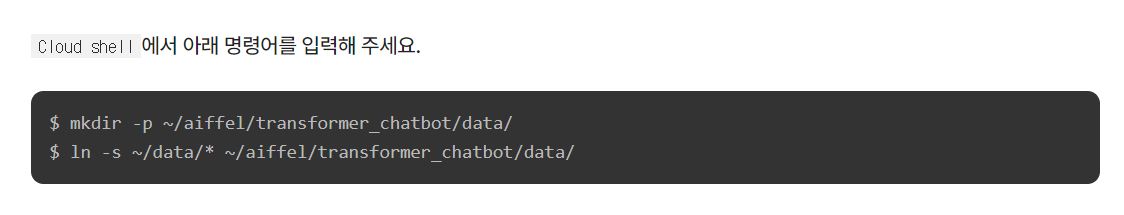

In [15]:
# 데이터 불러오기 및 데이터 확인
import pandas as pd

dataset_filepath = os.getenv('HOME') + '/aiffel/transformer_chatbot/data/ChatbotData .csv'
data = pd.read_csv(dataset_filepath)
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [16]:
# 데이터 개수
len(data)

11823

In [17]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 11823
print(MAX_SAMPLES)

11823


#### 데이터 전처리

In [18]:
# 전처리 함수 
def preprocess_sentence(sentence):
    sentence = sentence.strip()
    sentence = re.sub(r'[-=.#/!?:$}ㅠㅠ]', '', sentence) # 특수문자, 'ㅠㅠ'등의 표현을 전처리로 제거해 준다.
    return sentence

In [19]:
# 대화 데이터셋을 로드하고,질문과 대답을 각각 전처리한 후 반환하는 함수(데이터셋으로부터 질문과 대답을 추출하고, 각각에 대해 전처리를 수행한 후 리스트에 담아 반환하는 역할)
def load_conversations(): # 매개변수 없이 호출 가능한 함수
    inputs, outputs = [], [] # inputs: 전처리된 질문을 저장할 리스트
                             # outputs: 전처리된 대답을 저장할 리스트
    
    question = data['Q'] # 데이터셋에서 질문(Q)과 대답(A)에 해당하는 열을 추출
    answer = data['A']
    #labels = data['label']
    
    for _, line in enumerate(question):
        inputs.append(preprocess_sentence(line)) # 각각의 질문과 대답에 대해 preprocess_sentence 함수를 사용하여 전처리를 수행하고, 
                                                 # 그 결과를 inputs 및 outputs 리스트에 추가
                                                 # enumerate를 사용하여 라인 인덱스에 대응하는 반복문을 생성. 
                                                 # 실제 인덱스는 사용하지 않고 있다.
    
    for _, line in enumerate(answer):
        outputs.append(preprocess_sentence(line)) # 전처리된 질문 리스트 inputs와 전처리된 대답 리스트 outputs를 반환
        
    return inputs, outputs

In [21]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions)) # 샘플 수 확인
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


질문과 답변은 병렬적으로 구성되는 데이터셋이므로 두 샘플 수는 정확하게 일치해야 한다.

둘 다 11823개의 샘플이 저장되었다.

임의로 22번째 샘플(인덱스 상으로는 21번 샘플)을 출력해서 질문과 답변이 병렬적으로 잘 저장은 되었는지, 그리고 전처리 함수에서 의도했던 전처리가 진행되었는지 확인해 보자!

In [22]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요


전처리 후 데이터의 형태 확인해 보면, 특수문자들이 제거 된 것을 볼 수 있다.

#### 단어장(Vocabulary) 만들기

In [23]:
import tensorflow_datasets as tfds
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("슝=3 ")

살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐
슝=3 


이때 디코더의 문장 생성 과정에서 사용할 '시작 토큰'과 '종료 토큰'에 대해서도 임의로 단어장에 추가하여서 정수를 부여해 준다. 이미 생성된 단어장의 번호와 겹치지 않도록 각각 단어장의 크기와 그보다 1이 큰 수를 번호로 부여하면 되겠다.

In [24]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("슝=3")

슝=3


시작 토큰과 종료 토큰에 부여된 정수를 출력해보자.

In [25]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8186]
END_TOKEN의 번호 : [8187]


각각 8186과 8187라는 점에서 현재 단어장의 크기가 8186(0번부터 8185번)이라는 의미입니다.

두 개의 토큰을 추가해 주었기 때문에 단어장의 크기도 +2임을 명시해 주어야 합니다.

In [27]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8188


#### 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)
---
위에서 tensorflow_datasets의 SubwordTextEncoder를 사용해서 tokenizer를 정의하고 Vocabulary를 만들었다면, tokenizer.encode()로 각 단어를 정수로 변환할 수 있고 또는 tokenizer.decode()를 통해 정수 시퀀스를 단어 시퀀스로 변환할 수 있다.

예를 들어서 22번째 샘플을 tokenizer.encode()의 입력으로 사용해서 변환 결과를 보자.

In [28]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5772, 607, 2489, 4162]
정수 인코딩 후의 21번째 답변 샘플: [2348, 7522, 5, 6281, 103]


각 단어에 고유한 정수가 부여된 Vocabulary를 기준으로 단어 시퀀스가 정수 시퀀스로 인코딩된 결과를 확인할 수 있다. 위의 결과와 마찬가지로 질문과 답변 셋에 대해서 전부 정수 인코딩 을 수행한다. 이와 동시에 문장의 최대 길이를 정하고, 해당 길이로 패딩(padding) 한다.

In [29]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [30]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


정수 인코딩 과정을 수행하면서 샘플의 길이가 40을 넘는 경우는 샘플들을 필터링하였으므로 일부 샘플이 제외되었다. 단어장의 크기와 샘플의 개수를 확인해 보겠다.

In [31]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8188
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


#### 교사 강요(teaching forcing)
---
tf.data.Dataset API 는 훈련 프로세스의 속도가 빨라지도록 입력 파이프라인을 구축하는 API이다.

이를 적극 사용하기 위해서 질문과 답변의 쌍을 tf.data.Dataset의 입력으로 넣어주는 작업을 한다.

이때, 디코더의 입력과 실제값(레이블)을 정의해 주기 위해서는 교사 강요(Teacher Forcing) 이라는 언어 모델의 훈련 기법을 이해해야만 한다. 아래의 글을 통해 교사 강요에 대해 알아보자. (모두 읽을 필요는 없고, 교사 강요 부분까지만 읽어도 된다.)

* [위키독스: RNN 언어 모델](https://wikidocs.net/46496)

**Q. 교사 강요(Teacher Forcing) 를 사용하지 않았을 경우, 훈련 과정에서 훈련 속도가 지나치게 느려지는 경우가 있다고 합니다. 그 이유는 무엇인가요?**
: 교사 강요를 하지 않은 경우, 잘못된 예측이 다음 시점(time step)의 입력으로 들어가면서 연쇄적으로 예측 정확도에 영향을 미친다.

이전 자신의 출력이 현재 자신의 상태를 결정하는 모델을 자기회귀 모델(auto-regressive model, AR) 이라고 합니다. 앞서 교사 강요를 이해하기 위해 읽었던 글에 등장한 RNN 언어 모델은 대표적인 자기 회귀 모델의 예이며, 트랜스포머의 디코더 또한 자기회귀 모델입니다.

트랜스포머 디코더에서도 교사 강요(Teacher Forcing) 를 적용합니다.

**Q. 만약, answers의 한 샘플이 다음과 같았다고 해봅시다.**

**샘플 : '<START_TOKEN> I AM A STUDENT <END_TOKEN> <PAD> <PAD> <PAD> <PAD>'**

**<START_TOKEN>은 문장의 시작을 의미하는 시작 토큰, <END_TOKEN>은 문장의 끝을 의미하는 종료 토큰 <PAD>는 패딩을 위해 사용되는 패딩 토큰입니다.**

**교사 강요를 적용하기 위해서 위 샘플을 디코더의 입력과 레이블로 사용한다고 하였을 때, 각각 어떻게 수정해서 입력과 레이블로 사용해야 할까요?**
    
: 입력 : <START_TOKEN> I AM A STUDENT <END_TOKEN> <PAD> <PAD> <PAD> 레이블 : I AM A STUDENT <END_TOKEN> <PAD> <PAD> <PAD> <PAD> 
    
질문과 답변의 쌍을 tf.data.Dataset API의 입력으로 사용하여 파이프라인을 구성합니다. 이때, 교사 강요를 위해서 answers[:, :-1]를 디코더의 입력값, answers[:, 1:]를 디코더의 레이블로 사용합니다.

In [32]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


### 3. 모델 정의 및 학습하기

이제 앞서 사용한 인코더 층 함수와 디코더 층 함수를 사용하여 트랜스포머 함수를 정의한다.

In [33]:
# 트랜스포머 함수 정의
def transformer(vocab_size, # vocab_size: 어휘 사이즈 (단어 집합의 크기)
                num_layers, # num_layers: 인코더 및 디코더에 쌓을 레이어의 수
                units, # units: 레이어 내의 완전연결층의 출력 크기
                d_model, # d_model: 모델의 차원 크기
                num_heads, # num_heads: 멀티 헤드 어텐션에서 사용되는 헤드의 개수
                dropout, # dropout: Dropout을 적용하는 비율
                name="transformer"): # name: 모델의 이름 (기본값은 "transformer")
  inputs = tf.keras.Input(shape=(None,), name="inputs") # inputs: 인코더의 입력 데이터 (질문 등)
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs") # dec_inputs: 디코더의 입력 데이터 (이전 단어들의 번역 결과)

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda( # 인코더와 디코더에서 사용할 패딩 마스크 및 룩어헤드 마스크를 생성하는 Lambda 레이어를 정의
      create_padding_mask, output_shape=(1, 1, None), 
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder( # 앞서 정의한 encoder 함수를 호출하여 인코더를 생성하고, 입력과 패딩 마스크를 전달
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder( # 앞서 정의한 decoder 함수를 호출하여 디코더를 생성하고, 디코더 입력, 인코더 출력, 룩어헤드 마스크, 디코더 패딩 마스크를 전달
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층 - 디코더의 출력을 받아 완전연결층을 추가. 이 층은 최종 예측을 생성
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name) # 입력과 디코더 입력을 받아 출력을 반환하는 트랜스포머 모델을 생성하고 반환
print("슝=3")

슝=3


#### 모델 생성
---

num_layers, d-Model, units는 전부 사용자가 정할 수 있는 하이퍼파라미터 값이다.

논문에서 num_layers는 6, d-Model은 512였지만, 빠르고 원활한 훈련을 위해 여기서는 각 하이퍼파라미터를 논문에서보다는 작은 값을 사용한다.

In [34]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3150336     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

#### 2. 손실 함수(Loss function)
---

레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 한다.

In [35]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("슝=3")

슝=3


#### 3. 커스텀 된 학습률(Learning rate)
---
딥러닝 모델학습 시 learning rate는 매우 중요한 하이퍼파라미터이다. 최근에는 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법을 널리 사용하고 있다. 이런 방법을 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)이라고 한다.

논문에 나온 공식을 참고하여 커스텀 학습률 스케줄러를 통한 아담 옵티마이저를 사용한다. 논문에 나온 공식은 다음과 같다.
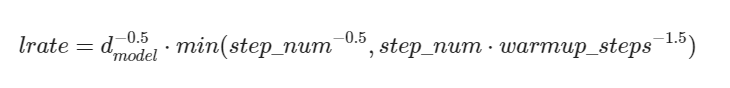

In [36]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


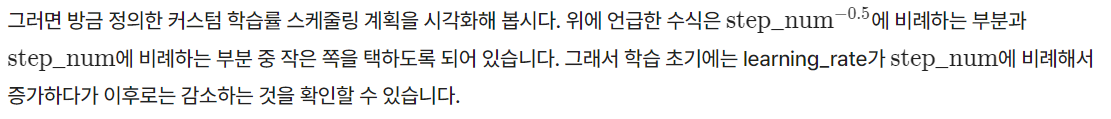

Text(0.5, 0, 'Train Step')

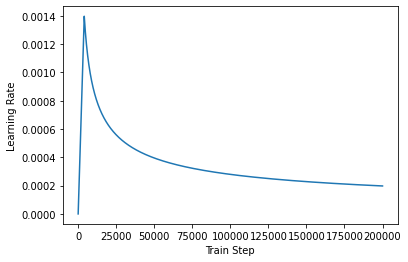

In [37]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

#### 모델 컴파일
---
손실 함수와 커스텀 된 학습률(learning rate)을 사용하여 모델을 컴파일한다.

In [38]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


#### 훈련하기
---
이제 학습을 진행해 보자.

In [39]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
185/185 [==============================] - 28s 53ms/step - loss: 1.2534 - accuracy: 0.0211
Epoch 2/20
185/185 [==============================] - 10s 53ms/step - loss: 1.0868 - accuracy: 0.0256
Epoch 3/20
185/185 [==============================] - 10s 52ms/step - loss: 0.9916 - accuracy: 0.0262
Epoch 4/20
185/185 [==============================] - 10s 53ms/step - loss: 0.9208 - accuracy: 0.0298
Epoch 5/20
185/185 [==============================] - 10s 53ms/step - loss: 0.8610 - accuracy: 0.0334
Epoch 6/20
185/185 [==============================] - 10s 53ms/step - loss: 0.7999 - accuracy: 0.0379
Epoch 7/20
185/185 [==============================] - 10s 53ms/step - loss: 0.7331 - accuracy: 0.0444
Epoch 8/20
185/185 [==============================] - 10s 53ms/step - loss: 0.6597 - accuracy: 0.0524
Epoch 9/20
185/185 [==============================] - 10s 53ms/step - loss: 0.5813 - accuracy: 0.0605
Epoch 10/20
185/185 [==============================] - 10s 54ms/step - loss: 0.498

### 4. 챗봇 테스트하기

예측(inference) 단계는 기본적으로 다음과 같은 과정을 거친다.

1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
2. 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
6. END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

위의 과정을 모두 담은 decoder_inference() 함수를 만든다.

In [40]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


임의의 입력 문장에 대해서 decoder_inference() 함수를 호출하여 챗봇의 대답을 얻는 sentence_generation() 함수를 만든다.

In [41]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


#### 임의의 문장으로부터 챗봇의 대답을 얻어보자.

In [42]:
sentence_generation('심심하다')

입력 : 심심하다
출력 : 저랑 놀아요


'저랑 놀아요'

In [43]:
sentence_generation('공부는 어려워')

입력 : 공부는 어려워
출력 : 확신이 없나봐요


'확신이 없나봐요'

In [44]:
sentence_generation('배고파')

입력 : 배고파
출력 : 뭐 좀 챙겨드세요


'뭐 좀 챙겨드세요'

In [45]:
sentence_generation('강아지 좋아해?')

입력 : 강아지 좋아해?
출력 : 마음이 따뜻할 것 같아요


'마음이 따뜻할 것 같아요'

In [46]:
sentence_generation('주말에 뭐 할까?')

입력 : 주말에 뭐 할까?
출력 : 저랑 놀아요


'저랑 놀아요'

In [47]:
sentence_generation('피곤하다')

입력 : 피곤하다
출력 : 시간적 여유가 생겨서 그런가봐요


'시간적 여유가 생겨서 그런가봐요'

In [49]:
sentence_generation('어떻게 하면 건강할까?')

입력 : 어떻게 하면 건강할까?
출력 : 주기적으로 해주는 게 좋죠


'주기적으로 해주는 게 좋죠'

In [50]:
sentence_generation('돈 많이 벌고 싶다')

입력 : 돈 많이 벌고 싶다
출력 : 저도요


'저도요'

In [51]:
sentence_generation('오늘 날씨 어때?')

입력 : 오늘 날씨 어때?
출력 : 날씨 어플에 물어보세요


'날씨 어플에 물어보세요'

* 전반적으로 답변들이 괜찮지만, 아쉬운 답변도 있다. ('어떻게 하면 건강할까? - 주기적으로 해주는 게 좋죠 등)
* 좀 더 학습을 해보자.
    * NUM_LAYERS = 4 (인코더와 디코더의 층의 개수 : 2 -> 4)
    * D_MODEL = 512 (인코더와 디코더 내부의 입, 출력의 고정 차원 : 256 -> 512)
    * EPOCHS = 20 -> 100

In [55]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 4 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model_1 = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model_1.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    10504192    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [56]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model_1.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


In [57]:
EPOCHS = 100
model_1.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/100
185/185 [==============================] - 38s 148ms/step - loss: 1.2022 - accuracy: 0.0216
Epoch 2/100
185/185 [==============================] - 28s 151ms/step - loss: 1.0387 - accuracy: 0.0257
Epoch 3/100
185/185 [==============================] - 28s 153ms/step - loss: 0.9641 - accuracy: 0.0272
Epoch 4/100
185/185 [==============================] - 28s 154ms/step - loss: 0.9143 - accuracy: 0.0305
Epoch 5/100
185/185 [==============================] - 28s 153ms/step - loss: 0.8572 - accuracy: 0.0340
Epoch 6/100
185/185 [==============================] - 28s 153ms/step - loss: 0.7888 - accuracy: 0.0391
Epoch 7/100
185/185 [==============================] - 29s 155ms/step - loss: 0.7141 - accuracy: 0.0462
Epoch 8/100
185/185 [==============================] - 28s 153ms/step - loss: 0.6336 - accuracy: 0.0550
Epoch 9/100
185/185 [==============================] - 28s 153ms/step - loss: 0.5488 - accuracy: 0.0645
Epoch 10/100
185/185 [==============================] - 28s 153m

185/185 [==============================] - 28s 153ms/step - loss: 0.0053 - accuracy: 0.1480
Epoch 80/100
185/185 [==============================] - 28s 153ms/step - loss: 0.0051 - accuracy: 0.1481
Epoch 81/100
185/185 [==============================] - 28s 153ms/step - loss: 0.0051 - accuracy: 0.1481
Epoch 82/100
185/185 [==============================] - 28s 153ms/step - loss: 0.0050 - accuracy: 0.1481
Epoch 83/100
185/185 [==============================] - 28s 153ms/step - loss: 0.0051 - accuracy: 0.1481
Epoch 84/100
185/185 [==============================] - 28s 153ms/step - loss: 0.0048 - accuracy: 0.1482
Epoch 85/100
185/185 [==============================] - 28s 153ms/step - loss: 0.0046 - accuracy: 0.1482
Epoch 86/100
185/185 [==============================] - 28s 153ms/step - loss: 0.0044 - accuracy: 0.1481
Epoch 87/100
185/185 [==============================] - 28s 153ms/step - loss: 0.0046 - accuracy: 0.1481
Epoch 88/100
185/185 [==============================] - 28s 153ms/st

In [71]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model_1(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


In [72]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


In [73]:
sentence_generation('돈 많이 벌고 싶다')

입력 : 돈 많이 벌고 싶다
출력 : 공부하세요


'공부하세요'

In [74]:
sentence_generation('오늘 날씨 어때?')

입력 : 오늘 날씨 어때?
출력 : 날씨 어플에 물어보세요


'날씨 어플에 물어보세요'

In [75]:
sentence_generation('강아지 좋아해?')

입력 : 강아지 좋아해?
출력 : 따뜻할 거 같아요


'따뜻할 거 같아요'

In [76]:
sentence_generation('주말에 뭐 할까?')

입력 : 주말에 뭐 할까?
출력 : 저랑 놀아요


'저랑 놀아요'

In [77]:
sentence_generation('공부는 어려워')

입력 : 공부는 어려워
출력 : 확신이 없나봐요


'확신이 없나봐요'

In [78]:
sentence_generation('어떻게 하면 건강할까?')

입력 : 어떻게 하면 건강할까?
출력 : 주기적으로 해주는 게 좋죠


'주기적으로 해주는 게 좋죠'

* '돈 많이 벌고 싶다'라는 말에 '공부하세요'라는 답변주는 것 외에는 큰 변화가 없는 것 같다.

### 회고문

요즘 많이 사용되는 모델인 만큼 트렌스포머 모델은 꼭 알아둬야 한다고 생각한다. 하지만 새로운 모델 구조이다보니, 이해하는 게 쉽지 않았다 ㅠㅠ 여전히 어려운 게 많고, 코드도 이해가 쉽지 않아서 좀 더 찾아서 공부해야 할 것 같다! 좀 더 추가적인 자료와 논문을 찾아서 노드 내용과 코드를 공부해야겠다.

#### K:
이번에는 좀 집중력이 떨어졌던 것 같다. 사실 keep해야 할 정도로 잘했던 모습이 없는 것 같아서 반성해야겠다.

#### P:
집중력이 많이 떨어져서 이번 트랜스포머 모델에 대해서 제대로 공부하지 못 했다. 중요한 모델인만큼 다시 집중해서 공부해야겠다.

#### T:
위키독스 내용을 여러 번 보면서 공부한다. 코드를 천천히 주석을 달면서 다시 이해하도록 해본다.